# Pitch number and far filed angle

In [5]:
import meep as mp
import math
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn")


/tmp/ipykernel_21394/1476887174.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


## Grating coupler simulation Configuration

In [6]:
def sweep_pitch_number(p_num=1):
    # if True compute flux (Gaussian source), if False compute DFT (Continue source)
    compute_flux = True
    # size of input and output waveguide
    w = 0.5
    h = 0.2

    # resolution size
    grid = 0.02
    resolution = 1 / grid

    # thickness of PML
    dpml = 1

    ##################### length parameter ################
    input_wvg_length = 5
    output_wvg_length = 5

    period = 0.707  # period of grating coupler
    duty_cycle = 0.53  # duty cycle of grating coupler
    number_period = p_num  # number of period of grating coupler
    sx = input_wvg_length + period * number_period + output_wvg_length + 2 * dpml

    ##################### height parameter ################
    Substrate_thickness = 0.5
    BOX_thickness = 2
    TOX_thickness = 0.7
    near_field_height = 1
    sy = (
        BOX_thickness
        + TOX_thickness
        + Substrate_thickness
        + near_field_height
        + 2 * dpml
    )

    cell = mp.Vector3(sx, sy, 0)

    # Material setting
    Si = mp.Medium(index=3.45)
    SiO2 = mp.Medium(index=1.44)
    SiN = mp.Medium(index=1.96)

    ####################### geometry ##########################
    Substrate_geo = mp.Block(
        material=Si,
        center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
        size=mp.Vector3(sx, Substrate_thickness),
    )
    BOX_geo = mp.Block(
        material=SiO2,
        center=mp.Vector3(
            y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml
        ),
        size=mp.Vector3(sx, BOX_thickness),
    )
    TOX_geo = mp.Block(
        material=SiO2,
        center=mp.Vector3(
            y=-0.5 * sy
            + Substrate_thickness
            + BOX_thickness
            + 0.5 * TOX_thickness
            + dpml
        ),
        size=mp.Vector3(sx, TOX_thickness),
    )
    input_waveguide_geo = mp.Block(
        material=SiN,
        center=mp.Vector3(
            -0.5 * sx + 0.5 * input_wvg_length + dpml,
            -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
        ),
        size=mp.Vector3(input_wvg_length, h),
    )
    output_waveguide_geo = mp.Block(
        material=SiN,
        center=mp.Vector3(
            0.5 * sx - 0.5 * output_wvg_length - dpml,
            -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
        ),
        size=mp.Vector3(output_wvg_length, h),
    )

    grating_coupler_geo = []
    for ii in range(1, number_period + 1):
        grating_coupler_geo.append(
            mp.Block(
                material=SiN,
                center=mp.Vector3(
                    -0.5 * sx
                    + input_wvg_length
                    + ii * period
                    - duty_cycle * period / 2
                    + dpml,
                    -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
                ),
                size=mp.Vector3(duty_cycle * period, h),
            )
        )

    geometry = [
        Substrate_geo,
        BOX_geo,
        TOX_geo,
        input_waveguide_geo,
        output_waveguide_geo,
        *grating_coupler_geo,
    ]

    ####################### geometry ##########################

    ####################### Sources ##########################
    wvl = 0.785
    fcen = 1 / wvl
    fwidth = 0.2 * fcen
    kpoint = mp.Vector3(1, 0, 0)

    sources = [
        mp.EigenModeSource(
            mp.GaussianSource(frequency=fcen, fwidth=fwidth),
            center=input_waveguide_geo.center,
            size=mp.Vector3(0, 3 * h),
            eig_band=1,
            eig_parity=mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq=True,
            direction=mp.NO_DIRECTION,
            eig_kpoint=kpoint,
        )
    ]
    # set nomrlized source: amplitude is 1 -> flux is 1
    sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
        fcen
    )

    ####################### Sources ##########################

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell,
        boundary_layers=[mp.PML(dpml)],
        sources=sources,
        geometry=geometry,
    )

    # ############### Monitor ###################
    nfreq = 1

    # src_region
    src_region = mp.FluxRegion(
        center=input_waveguide_geo.center + mp.Vector3(0.2, 0, 0),
        size=mp.Vector3(0, 5 * h, 0),
    )
    src_flux = sim.add_mode_monitor(fcen, 0, 1, src_region)

    src_dft = sim.add_dft_fields(
        [mp.Ez], fcen, fwidth, nfreq, center=src_region.center, size=src_region.size
    )

    # near_field_region
    near_region = mp.FluxRegion(
        center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
        size=mp.Vector3(sx - 2 * dpml, 0),
    )

    near_field = sim.add_mode_monitor(
        fcen,
        fwidth,
        nfreq,
        near_region,
    )

    near_dft = sim.add_dft_fields(
        [mp.Ez], fcen, fwidth, nfreq, center=near_region.center, size=near_region.size
    )

    # near2far_field
    n2f_field = sim.add_near2far(
        fcen,
        0,
        nfreq,
        near_region,
    )

    out_region = mp.FluxRegion(
        center=mp.Vector3(
            output_waveguide_geo.center.x, output_waveguide_geo.center.y, 0
        ),
        size=mp.Vector3(0, 3 * h, 0),
    )
    out_field = sim.add_mode_monitor(
        fcen,
        0,
        1,
        out_region,
    )
    # run simulation

    # monitor point
    mpt = mp.Vector3(0.5 * sx - dpml - 1, output_waveguide_geo.center.y)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
    )
    ff_distance = 1e6  # far-field distance from near-field monitor
    ff_angle = 80  # far-field cone angle
    ff_npts = 1000  # number of far-field points
    # single-side far-field length
    ff_length = ff_distance * math.tan(math.radians(ff_angle))  # far-field length
    # [-ff_length, ff_length]
    ff_lengths = np.linspace(-ff_length, ff_length, ff_npts)  # far-field lengths
    # resolution
    ff_res = ff_npts / (2 * ff_length)  # far-field length resolution

    ff = sim.get_farfields(
        n2f_field,
        ff_res,
        center=mp.Vector3(0, ff_distance),
        size=mp.Vector3(x=2 * ff_length),
    )
    # [-angle, angle]
    angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]
    rel_enh = np.abs(ff["Ez"]) ** 2

    return rel_enh

In [13]:
rel_enhs = []
for num in range(1, 15, 1):
    rel_enh = sweep_pitch_number(num)
    rel_enhs.append(rel_enh)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000411034 s
Working in 2D dimensions.
Computational cell is 12.7 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (12.707,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (12.707,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (12.707,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-2.8535,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (2.8535,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant 

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 3502 (time=35.02), 0.00114237 s/step
field decay(t = 50.01): 0.38369795651259264 / 0.38369795651259264 = 1.0
on time step 7038 (time=70.38), 0.00113124 s/step
field decay(t = 100.01): 0.00016122671201436632 / 0.38369795651259264 = 0.0004201917400857333
on time step 10558 (time=105.58), 0.0011365 s/step
on time step 14064 (time=140.64), 0.00114115 s/step


field decay(t = 150.02): 3.42311061188962e-08 / 0.38369795651259264 = 8.921367846214413e-08
run 0 finished at t = 150.02 (15002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000334024 s
Working in 2D dimensions.
Computational cell is 13.42 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (13.414,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (13.414,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (13.414,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-3.207,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 3268 (time=32.68), 0.00122409 s/step
field decay(t = 50.01): 0.3241270998613716 / 0.3241270998613716 = 1.0
on time step 6613 (time=66.13), 0.00119604 s/step
on time step 9980 (time=99.8), 0.00118811 s/step
field decay(t = 100.01): 0.0002559356311757173 / 0.3241270998613716 = 0.000789615034611979
on time step 13336 (time=133.36), 0.00119193 s/step


field decay(t = 150.02): 5.4497008131915565e-08 / 0.3241270998613716 = 1.6813468591556772e-07
run 0 finished at t = 150.02 (15002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000420094 s
Working in 2D dimensions.
Computational cell is 14.12 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (14.121,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (14.121,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (14.121,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-3.5605,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.841

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 3202 (time=32.02), 0.00124927 s/step
field decay(t = 50.01): 0.3045433778516041 / 0.3045433778516041 = 1.0
on time step 6433 (time=64.33), 0.00123804 s/step
on time step 9667 (time=96.67), 0.00123699 s/step
field decay(t = 100.01): 0.0002523854407169175 / 0.3045433778516041 = 0.0008287339639343535
on time step 12918 (time=129.18), 0.00123045 s/step


field decay(t = 150.02): 2.6176115576558498e-08 / 0.3045433778516041 = 8.595201038754296e-08
run 0 finished at t = 150.02 (15002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000339985 s
Working in 2D dimensions.
Computational cell is 14.82 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (14.828,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (14.828,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (14.828,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-3.914,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 3075 (time=30.75), 0.00130122 s/step
field decay(t = 50.01): 0.24945133614792359 / 0.24945133614792359 = 1.0
on time step 6225 (time=62.25), 0.00127018 s/step
on time step 9450 (time=94.5), 0.00124053 s/step
field decay(t = 100.01): 0.000531832869930975 / 0.24945133614792359 = 0.0021320105081161014
on time step 12610 (time=126.1), 0.00126598 s/step
field decay(t = 150.02): 3.155410469757816e-07 / 0.24945133614792359 = 1.2649402959648494e-06
run 0 finished at t = 150.02 (15002 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000437021 s
Working in 2D dimensions.
Computational cell is 15.54 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (15.535,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (15.535,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (15.535,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-4.2675,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (4.2675,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2963 (time=29.63), 0.00135042 s/step
field decay(t = 50.01): 0.15792293804159968 / 0.15792293804159968 = 1.0
on time step 5975 (time=59.75), 0.00132846 s/step
on time step 8996 (time=89.96), 0.00132421 s/step
field decay(t = 100.01): 0.0023150708426047982 / 0.15792293804159968 = 0.01465949703896066
on time step 12009 (time=120.09), 0.00132786 s/step
field decay(t = 150.02): 4.5733830344736816e-07 / 0.15792293804159968 = 2.8959586816127824e-06
run 0 finished at t = 150.02 (15002 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000365973 s
Working in 2D dimensions.
Computational cell is 16.24 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (16.242,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (16.242,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (16.242,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-4.621,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (4.621,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant e

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2853 (time=28.53), 0.00140206 s/step
field decay(t = 50.01): 0.11596998406586155 / 0.11596998406586155 = 1.0
on time step 5759 (time=57.59), 0.00137665 s/step
on time step 8671 (time=86.71), 0.00137386 s/step
field decay(t = 100.01): 0.003301124632698209 / 0.11596998406586155 = 0.028465336606612254
on time step 11586 (time=115.86), 0.00137251 s/step
on time step 14502 (time=145.02), 0.00137183 s/step
field decay(t = 150.02): 2.041721623642079e-06 / 0.11596998406586155 = 1.7605604071503076e-05
on time step 17414 (time=174.14), 0.00137382 s/step
field decay(t = 200.03): 1.0477224692101193e-10 / 0.11596998406586155 = 9.034427982805429e-10
run 0 finished at t = 200.03 (

-----------
Initializing structure...
time for choose_chunkdivision = 0.000379086 s
Working in 2D dimensions.
Computational cell is 16.94 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (16.949,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (16.949,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (16.949,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-4.9745,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (4.9745,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2719 (time=27.19), 0.00147144 s/step
field decay(t = 50.01): 0.09539881576543831 / 0.09539881576543831 = 1.0
on time step 5464 (time=54.64), 0.00145723 s/step
on time step 8219 (time=82.19), 0.00145205 s/step
field decay(t = 100.01): 0.013706491495044314 / 0.09539881576543831 = 0.14367569854058912
on time step 10987 (time=109.87), 0.00144529 s/step
on time step 13756 (time=137.56), 0.00144464 s/step
field decay(t = 150.02): 2.638040148079832e-06 / 0.09539881576543831 = 2.765275571728384e-05
on time step 16523 (time=165.23), 0.00144568 s/step
on time step 19304 (time=193.04), 0.00143878 s/step
field decay(t = 200.03): 1.779279127624492e-10 / 0.09539881576543831 = 1.8

-----------
Initializing structure...
time for choose_chunkdivision = 0.000514984 s
Working in 2D dimensions.
Computational cell is 17.66 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (17.656,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (17.656,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (17.656,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-5.328,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (5.328,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant e

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2637 (time=26.37), 0.00151732 s/step
field decay(t = 50.01): 0.09972709476700153 / 0.09972709476700153 = 1.0
on time step 5315 (time=53.15), 0.00149398 s/step
on time step 8000 (time=80), 0.00149008 s/step
field decay(t = 100.01): 0.017284674074792755 / 0.09972709476700153 = 0.1733197393865327
on time step 10685 (time=106.85), 0.00149017 s/step
on time step 13373 (time=133.73), 0.00148866 s/step
field decay(t = 150.02): 9.062423339992642e-07 / 0.09972709476700153 = 9.087222846675452e-06
run 0 finished at t = 150.02 (15002 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000405073 s
Working in 2D dimensions.
Computational cell is 18.36 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (18.363,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (18.363,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (18.363,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-5.6815,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (5.6815,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2548 (time=25.48), 0.0015704 s/step
field decay(t = 50.01): 0.07786828917389452 / 0.07786828917389452 = 1.0
on time step 5135 (time=51.35), 0.00154654 s/step
on time step 7738 (time=77.38), 0.00153697 s/step
field decay(t = 100.01): 0.011044406816243055 / 0.07786828917389452 = 0.14183446090075025
on time step 10328 (time=103.28), 0.00154463 s/step
on time step 12931 (time=129.31), 0.00153688 s/step
field decay(t = 150.02): 8.189263752906495e-07 / 0.07786828917389452 = 1.0516814790444838e-05
on time step 15534 (time=155.34), 0.00153681 s/step
on time step 18147 (time=181.47), 0.00153128 s/step


field decay(t = 200.03): 7.112642800626412e-11 / 0.07786828917389452 = 9.134196829138682e-10
run 0 finished at t = 200.03 (20003 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000414133 s
Working in 2D dimensions.
Computational cell is 19.08 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (19.07,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (19.07,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (19.07,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-6.035,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2426 (time=24.26), 0.0016494 s/step
on time step 4899 (time=48.99), 0.00161778 s/step
field decay(t = 50.01): 0.047990933742722466 / 0.047990933742722466 = 1.0
on time step 7368 (time=73.68), 0.0016205 s/step
on time step 9835 (time=98.35), 0.00162205 s/step
field decay(t = 100.01): 0.010733413055571253 / 0.047990933742722466 = 0.22365501603100002
on time step 12308 (time=123.08), 0.00161767 s/step
on time step 14780 (time=147.8), 0.00161856 s/step
field decay(t = 150.02): 8.694808174004462e-07 / 0.047990933742722466 = 1.8117605755739182e-05
on time step 17248 (time=172.48), 0.00162107 s/step
on time step 19750 (time=197.5), 0.00159921 s/step
field decay(t = 200.03)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000472069 s
Working in 2D dimensions.
Computational cell is 19.78 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (19.777,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (19.777,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (19.777,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-6.3885,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (6.3885,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2315 (time=23.15), 0.00172817 s/step
on time step 4658 (time=46.58), 0.00170784 s/step
field decay(t = 50.01): 0.02850003826616796 / 0.02850003826616796 = 1.0
on time step 7020 (time=70.2), 0.00169369 s/step
on time step 9409 (time=94.09), 0.00167454 s/step
field decay(t = 100.01): 0.017192785439942414 / 0.02850003826616796 = 0.6032548194979708
on time step 11765 (time=117.65), 0.00169786 s/step
on time step 14203 (time=142.03), 0.00164103 s/step
field decay(t = 150.02): 3.4016908745615194e-07 / 0.02850003826616796 = 1.1935741428809322e-05
on time step 16652 (time=166.52), 0.00163339 s/step
on time step 19103 (time=191.03), 0.00163244 s/step
field decay(t = 200.03):

-----------
Initializing structure...
time for choose_chunkdivision = 0.000531912 s
Working in 2D dimensions.
Computational cell is 20.48 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (20.484,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (20.484,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (20.484,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-6.742,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (6.742,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant e

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2317 (time=23.17), 0.00172704 s/step
on time step 4610 (time=46.1), 0.00174454 s/step
field decay(t = 50.01): 0.032803081707953374 / 0.032803081707953374 = 1.0
on time step 6913 (time=69.13), 0.00173699 s/step
on time step 9230 (time=92.3), 0.00172682 s/step
field decay(t = 100.01): 0.019138191461276065 / 0.032803081707953374 = 0.583426631426396
on time step 11553 (time=115.53), 0.00172204 s/step
on time step 13894 (time=138.94), 0.00170924 s/step
field decay(t = 150.02): 1.9875596525517346e-07 / 0.032803081707953374 = 6.059063810671894e-06
run 0 finished at t = 150.02 (15002 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000540018 s
Working in 2D dimensions.
Computational cell is 21.2 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (21.191,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (21.191,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (21.191,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-7.0955,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (7.0955,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant 

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2228 (time=22.28), 0.00179574 s/step
on time step 4485 (time=44.85), 0.00177277 s/step
field decay(t = 50.01): 0.03123191402159742 / 0.03123191402159742 = 1.0
on time step 6743 (time=67.43), 0.00177219 s/step
on time step 9011 (time=90.11), 0.00176375 s/step
field decay(t = 100.01): 0.015516494064986617 / 0.03123191402159742 = 0.4968153426093799
on time step 11276 (time=112.76), 0.00176624 s/step
on time step 13537 (time=135.37), 0.00176918 s/step
field decay(t = 150.02): 3.246545724715878e-07 / 0.03123191402159742 = 1.0394962417195547e-05
on time step 15800 (time=158), 0.00176777 s/step
on time step 18063 (time=180.63), 0.0017682 s/step


field decay(t = 200.03): 1.046758987207908e-08 / 0.03123191402159742 = 3.3515684837120636e-07
run 0 finished at t = 200.03 (20003 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000430107 s
Working in 2D dimensions.
Computational cell is 21.9 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (21.898,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (21.898,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (21.898,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-7.449,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 2128 (time=21.28), 0.00188039 s/step
on time step 4293 (time=42.93), 0.00184817 s/step
field decay(t = 50.01): 0.021597911742396503 / 0.021597911742396503 = 1.0
on time step 6462 (time=64.62), 0.00184469 s/step
on time step 8639 (time=86.39), 0.00183749 s/step
field decay(t = 100.01): 0.009748490339801642 / 0.021597911742396503 = 0.45136263431734674
on time step 10816 (time=108.16), 0.00183782 s/step
on time step 12996 (time=129.96), 0.0018355 s/step
field decay(t = 150.02): 1.3490630128773795e-07 / 0.021597911742396503 = 6.246265976859148e-06
run 0 finished at t = 150.02 (15002 timesteps)


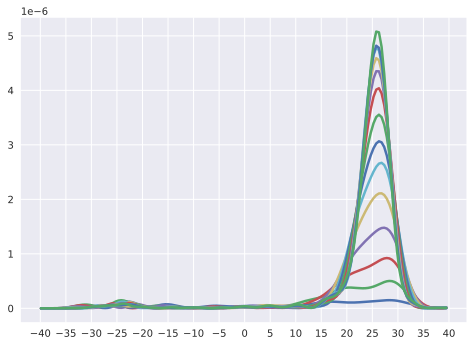

In [26]:
ff_distance = 1e6  # far-field distance from near-field monitor
ff_angle = 80  # far-field cone angle
ff_npts = 1000  # number of far-field points
# single-side far-field length
ff_length = ff_distance * math.tan(math.radians(ff_angle))  # far-field length
# [-ff_length, ff_length]
ff_lengths = np.linspace(-ff_length, ff_length, ff_npts)  # far-field lengths
# resolution
ff_res = ff_npts / (2 * ff_length)  # far-field length resolution

# [-angle, angle]
angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]

angle_minlim = np.argmin(np.abs(np.array(angles)+40))
angle_maxlim = np.argmin(np.abs(np.array(angles)-40))

for ii in range(0, len(rel_enhs), 1):
    plt.plot(
        angles[angle_minlim:angle_maxlim],
        rel_enhs[ii][angle_minlim:angle_maxlim],
        "-",
        linewidth=2.5,
    )
    plt.xticks(range(-40, 41, 5))